This loan structure model compares the three different loan policies which shows how much a lender incurs the cost (Overall Interest on repayment) on buying loan of large term period or tenure. It is further analyze through plotting the chart.

In [43]:
import pandas as pd
import numpy as np
from datetime import date
import numpy_financial as npf 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
def loan_structure(rate_of_interest, term_duration, yearly_installment, principal, add_principal=0, start_date=date.today()):
    """ Calculate the Loan Structure given the loan details
     Args:
        rate_of_interest: The annual interest rate for this loan
        term_duration: term period of the loan
        yearly_installment: Number of payments in a year
        principal: Amount lended
        add_principal (optional): Additional payments to be made each period. Assume 0 if nothing provided.
                                   must be a value less then 0, the function will convert a positive value to
                                   negative
        start_date (optional): Start date. Will start on first of next month if none provided
    """
    # additional payment will deducted from remaing principal
    if add_principal > 0:
        add_principal = -add_principal    
    # Creating an index of the payment dates
    aray = pd.date_range(start_date, periods=term_duration * yearly_installment, freq='MS')
    aray.name = "Payment_Date"
    
    # Build up the loan structure as a DataFrame
    df = pd.DataFrame(index=aray,columns=['Payment', 'Principal', 'Interest', 
                                         'Additional_Principal', 'Curr_Balance'], dtype='float')
    
    # Add index by period (start at 1 not 0)
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    
    # Calculate the payment, principal and interests amounts using built in numpy_financial functions
    period_payment = npf.pmt(rate_of_interest/yearly_installment, term_duration*yearly_installment, principal)
    df["Payment"] = period_payment
    df["Principal"] = npf.ppmt(rate_of_interest/yearly_installment, df.index, term_duration*yearly_installment, principal)
    df["Interest"] = npf.ipmt(rate_of_interest/yearly_installment, df.index, term_duration*yearly_installment, principal)
        
    # Roundoff
    df = df.round(2)
    # Add in the additional principal payments
    df["Additional_Principal"] = add_principal
    
    # Store the Cumulative Principal Payments and ensure it never gets larger than the original principal
    df["Cum_Principal"] = (df["Principal"] + df["Additional_Principal"]).cumsum()
    df["Cum_Principal"] = df["Cum_Principal"].clip(lower=-principal)
    
    # Calculate the current balance for each period
    df["Curr_Balance"] = principal + df["Cum_Principal"]
    
    # Determining the last payment date
    try:
        last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
    except ValueError:
        last_payment = df.last_valid_index()
    
    last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
        
    # Truncate the data frame if we have additional principal payments:
    if add_principal != 0:
        df = df.loc[0:last_payment].copy() # Remove the extra payment periods
        df.loc[last_payment, "Principal"] = -(df.loc[last_payment-1, "Curr_Balance"]) # Calculate the principal for the last row
        df.loc[last_payment, "Payment"] = df.loc[last_payment, ["Principal", "Interest"]].sum() # Calculate the total payment for the last row
        df.loc[last_payment, "Additional_Principal"] = 0  # Zero out the additional principal
        
    # Get the payment info into a DataFrame in column order
    payment_info = (df[["Payment", "Principal", "Additional_Principal", "Interest"]]
                    .sum().to_frame().T)
     # Format the Date DataFrame'
    payment_details = pd.DataFrame.from_dict(dict([('payoff_date', [last_payment_date]),
                                               ('Interest Rate', [rate_of_interest]),
                                               ('Number of years', [term_duration])
                                              ]))
    # Add a column showing how much we pay each period.
    # Combine addl principal with principal for total payment
    payment_details["Period_Payment"] = round(period_payment, 2) + add_principal
    
    payment_summary = pd.concat([payment_details, payment_info], axis=1)
    return df, payment_summary
structure1, stats1 = loan_structure(0.065, 10, 12, 100000, add_principal=0)
structure2, stats2 = loan_structure(0.065, 15, 12, 100000, add_principal=0)
structure3, stats3 = loan_structure(0.065, 20, 12, 100000, add_principal=0)


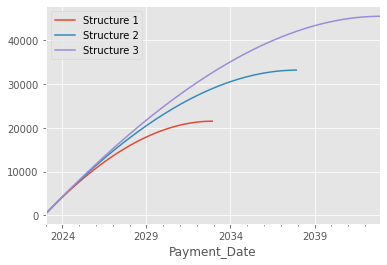

In [39]:

structure1["Cum_Interest"] = structure1["Interest"].abs().cumsum()
structure2["Cum_Interest"] = structure2["Interest"].abs().cumsum()
structure3["Cum_Interest"] = structure3["Interest"].abs().cumsum()

fig, ax = plt.subplots(1, 1)


structure1.plot(x='Payment_Date', y='Cum_Interest', label="Structure 1", ax=ax )
structure2.plot(x='Payment_Date', y='Cum_Interest', label="Structure 2", ax=ax)
structure3.plot(x='Payment_Date', y='Cum_Interest', label="Structure 3", ax=ax)

ax.legend();